# Convolutional Neural Networks in Pytorch

This tutorial expects a basic understanding of pytorch and convolutional networks and focuses on pytorch-specific implementation concerns.

* `torch.nn` documentation http://pytorch.org/docs/master/nn.html
* Convolution animations. Make sure to understand these animations so you can visualize stride, padding, etc. https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* Simple CNN model trained on MNIST: https://github.com/cmudeeplearning11785/deep-learning-tutorials/blob/master/recitation-4/pytorch-mnist-cnn-example.py
* If you want to look at something more complicated, check out the ResNet implementation in torchvision: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [1]:
import torch
import torch.nn.functional as F
from torch import autograd, nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

## Data Format

Dimension ordering is very important. For pytorch:

* 2D data like images should be `(samples, channels, height, width)` sometimes called "NCHW" or "channels first"
* 1D data like stock prices should be `(samples, channels, time)`
* 2D filters should be `(out_channels, in_channels, height, width)`
* 1D filters should be `(out_channels, in_channels, time)`

Different frameworks (e.g., TensorFlow) use different dimension orderings so be very careful, especially when implementing code or reading data targeted at a different framework.

Note most image data is RGB but some is BGR  or ARGB.

In [2]:
input_image = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(input_image.size())
input_signal = autograd.Variable(torch.randn(1,40,100)) # 40 dimensional signal for 100 timesteps
print(input_signal.size())

torch.Size([1, 3, 32, 32])
torch.Size([1, 40, 100])


## Convolutional Layers

The `torch.nn` module provides layers for CNNs. Use in the same way as other modules. Please refer to the documentation for details. Some of the most common layers you will use:

* `torch.nn.Conv2d`
* `torch.nn.ConvTranspose2d`
* `torch.nn.MaxPool2d`
* `torch.nn.AvgPool2d`


In [3]:
# Create layers
layer_c2d = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=2)
layer_avg = torch.nn.AvgPool2d(kernel_size=32)

In [4]:
# Use layers directly
y = layer_c2d(input_image)
print(y.size())

torch.Size([1, 20, 32, 32])


In [5]:
# Add layers to model
model = torch.nn.Sequential(layer_avg, layer_c2d)
y = model(input_image)
print(y.size())

torch.Size([1, 20, 1, 1])


## Convolutional Functions

The `torch.nn.functional` module provides low-level functions. Depending on what kinds of models you are making, you may never have to use these functions, and use pre-made layers instead. When using the functional module, you need to instantiate parameters yourself.

http://pytorch.org/docs/0.1.12/nn.html#torch-nn-functional

Example low-level functions:

* `F.max_pool2d`
* `F.dropout2d`
* `F.conv2d`

In [6]:
filters = autograd.Variable(torch.randn(20,3,5,5)) # 5x5 filter from 3 dimensions to 20
y=F.conv2d(input_image, filters, padding=2)
print(y.size())

torch.Size([1, 20, 32, 32])


In [7]:
filters = autograd.Variable(torch.randn(256,40,5)) # 5 wide filter from 40 dimensions to 256
y=F.conv1d(input_signal, filters, padding=2)
print(y.size())

torch.Size([1, 256, 100])


For example, if you generate the kernel using a neural network, you will have to use the functional module instead of a standard convolutional layer.

## Padding

Simple 0-padding can be accomplished using the `padding` keyword argument of many functions. Normally, you will be using the same vertical and horizontal padding but you can also pass a tuple `(H,W)`. Padding is applied symmetrically.

In [8]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=0)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=1)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=2)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=3)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=(0,3))(inputs).size())

torch.Size([1, 20, 26, 26])
torch.Size([1, 20, 28, 28])
torch.Size([1, 20, 30, 30])
torch.Size([1, 20, 32, 32])
torch.Size([1, 20, 26, 32])


For more complicated padding, use a padding layer before your convolution.

* Single int: apply to all sides
* tuple (H,W): apply H to top and bottom, W to left and right
* tuple (left, right, top, bottom)

In [9]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
y = torch.nn.Conv2d(3, 20, 7)(torch.nn.ReplicationPad2d(3)(inputs))
print(y.size())

torch.Size([1, 20, 32, 32])


Common padding layers:

* torch.nn.ReplicationPad2d
* torch.nn.ReflectionPad2d
* torch.nn.ZeroPad2d
* torch.nn.ConstantPad2d

## Normalization and Dropout

Don't forget BatchNorm2d and Dropout2d if you want to improve performance!

In [10]:
h = nn.Conv2d(3, 20, 5, padding=2)(input_image)
h = nn.BatchNorm2d(20)(h)
h = F.relu(h)
h = nn.Dropout2d(0.5)(h)
print(h.size())

torch.Size([1, 20, 32, 32])


## Downsampling

You can downsample using pooling operations or strided convolutions.

In [11]:
# Simple pooling operations
print(nn.MaxPool2d(2)(input_image).size())
print(nn.AvgPool2d(2)(input_image).size())

torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 16, 16])


In [12]:
# Strided convolution
layer = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=2, padding=2)
print(layer(input_image).size())

torch.Size([1, 20, 16, 16])


## Upsampling

Some operations help upsample images.

In [13]:
image_feats = autograd.Variable(torch.randn(1,20,16,16))

In [14]:
# Simple upsampling by linear or nearest neighbor
h = nn.Upsample(scale_factor=2, mode='nearest')(image_feats)
print(h.size())

torch.Size([1, 20, 32, 32])


/Users/simralchaudhary/miniconda3/envs/capstone/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [15]:
# Upsample by convolution and shuffle
h = nn.Conv2d(20, 3*2*2, 5, padding=2)(image_feats)
print(h.size())
h = nn.PixelShuffle(2)(h)
print(h.size())

torch.Size([1, 12, 16, 16])
torch.Size([1, 3, 32, 32])


In [16]:
# Transposed convolution
print(input_image.size())
downsample = nn.Conv2d(3, 20, 4, stride=2, padding=2)
upsample = nn.ConvTranspose2d(20, 3, 4, stride=2, padding=2)
h = downsample(input_image)
print(h.size())
output = upsample(h)
print(output.size())

torch.Size([1, 3, 32, 32])
torch.Size([1, 20, 17, 17])
torch.Size([1, 3, 32, 32])


## Reading Image Data

For an example of reading an image dataset, see this tutorial: 
http://pytorch.org/tutorials/beginner/data_loading_tutorial.html

You can load images from image files on-the-fly or perform preprocessing and load images from numpy files or formats. Pytorch provides utilities for reading images from a folder.

**Warning** `skimage`, `Pillow` and `matplotlib` expect (H, W, channels). Make sure to transpose dimensions when going to and from pytorch.

(273, 185, 3)


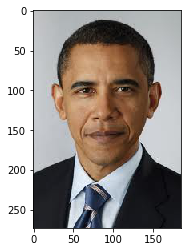

In [17]:
# Read an image using skimage
from skimage import io
image = io.imread('image_folder/face1/image1.jpg')
print(image.shape)
# Display an image
plt.imshow(image)
plt.show()

(480, 480, 3)


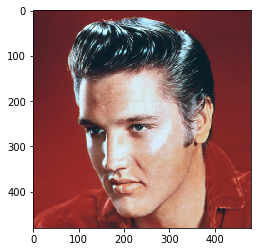

In [18]:
# Read using Pillow
from PIL import Image
image = np.array(Image.open('image_folder/face2/image2.jpg'))
print(image.shape)
plt.imshow(image)
plt.show()

(2, 3, 100, 100)
Label: 1


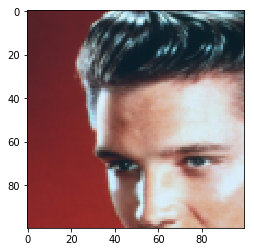

Label: 0


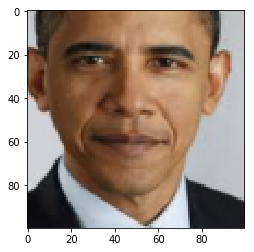

In [19]:
# Use torch ImageFolder
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
face_dataset = datasets.ImageFolder(root='image_folder',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(face_dataset,
                                             batch_size=2,
                                             shuffle=True,
                                             num_workers=1)
for x,y in dataset_loader:
    x = x.numpy()
    print(x.shape)
    for img, label in zip(x,y):
        print("Label: {}".format(label))
        plt.imshow(img.transpose((1,2,0)))
        plt.show() 

## Basic Pytorch Model

In [20]:
class BasicCNNModule():
        def __init__(self, in_feature, num_class):

            self.conv1 = nn.Conv2d(in_feature, in_feature*2,
                        kernel_size=5, stride=1)
            self.conv2 = nn.Conv2d(in_feature*2, in_feature*2,
                        kernel_size=6, stride=2)

            self.act1 = nn.Tanh()
            self.act2 = nn.ReLU()
            self.linear = nn.Linear(in_feature*10, num_class)

            self.__layers = [self.conv1, self.act1,
                           self.conv2, self.act2,
                           self.linear]

        def forward(self, x):
            for layer in self.__layers:
                x = layer(x)

            return x
        
        def backward(self, delta):
            n = len(self.__layers)

            for i in self.__layers[::-1]:
                delta = self.__layers[i].backward(delta)

            return
        
print(BasicCNNModule(100, 10))

## Serialization of Models

In [ ]:
args,kwargs = [], {}
model = BasicCNNModule(100, 10)

# save only model parameters
PATH = "./models/"
torch.save(model.state_dict(), PATH)

# load a saved model parameters
model = BasicCNNModule(100, 10)
model.load_state_dict(torch.load(PATH))

## Less optimised approaches ->
# saving the entire model
torch.save(the_model, PATH)

# load the saved model
the_model = torch.load(PATH)


## Pre-trained models

Training CNN models from scratch requires a lot of data. Hence we often use pre-trained models to alleviate this problem. For CNNs, pre-trained models are readily available for famos architectures such as VGG, ResNet and Inception Net.

When you set `pretrained=True`, torchvision automatically downloads the model for you, and initializes weights from there. If this does not work, run the following:
```
>> wget https://download.pytorch.org/models/vgg16-397923af.pth
>> mv vgg16-397923af.pth ~/.torch/models/vgg16-397923af.pth
```

You can find all other pretrained models included at https://pytorch.org/docs/stable/torchvision/models.html.

In [23]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True) # this might take a while
vgg16.eval()
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

We can build a VGG feature extractor. These are often useful in downstream tasks, for example learning deep visual semantic embeddings (https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41473.pdf). This allows us to use features trained on large datasets like ImageNet, and use on tasks which have lesser data.

``` vgg16.features ``` gives us convolutional features. Often, even taking all the layers until the last classification layer also suffices.

In [24]:
vgg16_feature_extractor = vgg16.features
# print('VGG feature extractor', vgg16_feature_extractor)
print(vgg16_feature_extractor(Variable(torch.rand(1, 3, 224, 224))).size())
print(vgg16_feature_extractor(Variable(torch.rand(1, 3, 224, 224))).view(1, -1).size()) # flatten conv features

vgg16_4096 = models.vgg16(pretrained=True)
new_classifier = nn.Sequential(*list(vgg16_4096.classifier.children())[:-1]) # remove just the last layer
vgg16_4096.classifier = new_classifier
print(vgg16_4096(Variable(torch.rand(1, 3, 224, 224))).size())

torch.Size([1, 512, 7, 7])
torch.Size([1, 25088])
torch.Size([1, 4096])


In [25]:
resnet = models.resnet152(pretrained=True) # this might take a while
resnet.eval() # for resnet, this is VERY important.
modules = list(resnet.children())[:-1]
resnet_feats = nn.Sequential(*modules)
print(resnet_feats(Variable(torch.rand(1, 3, 224, 224))).size())

torch.Size([1, 2048, 1, 1])


## Debugging CNNs

While debugging CNN models, its often very helpful to visualize the filters: visualizing the weights learned could tell us if the CNN is learning useful features at all. Remember that convolutional layers work as feature extractors - at lower levels of the hierarchy, you should ideally be seeing low level feaure extractors like edge detectors, Gaussian filters.

Furthermore two other heuristics you could look at:
1. At least a significant portion of filters should be active for every image (and this should probably change from one image class to another). Otherwise you have a lot of dead filters.
2. Your feature maps should be kind of uncorrelated. If you see the same outputs for many filters in your CNN, you have redundant model capacity, or something went wrong in training.

In either case, looking at train-val loss curves also helps (should not have unusual shapes) along with monitoring gradient norms (should not grow super-large or be super small).

Let's take only a portion of the pretrained VGG model, pass it through the first layer (which has 64 filters/kernels) and see what the output looks like? To make a grid, we are going to use `torchvision.utils.make_grid()`. You can refer to https://gist.github.com/anonymous/bf16430f7750c023141c562f3e9f2a91 for more on how to use `make_grid()`.

To really dig deep into visualizing CNNs, you can use this: https://github.com/utkuozbulak/pytorch-cnn-visualizations

conv1 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
)
conv5 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
)
input:  torch.Size([2, 3, 100, 100]) output:  torch.Size([2, 64, 100, 100])


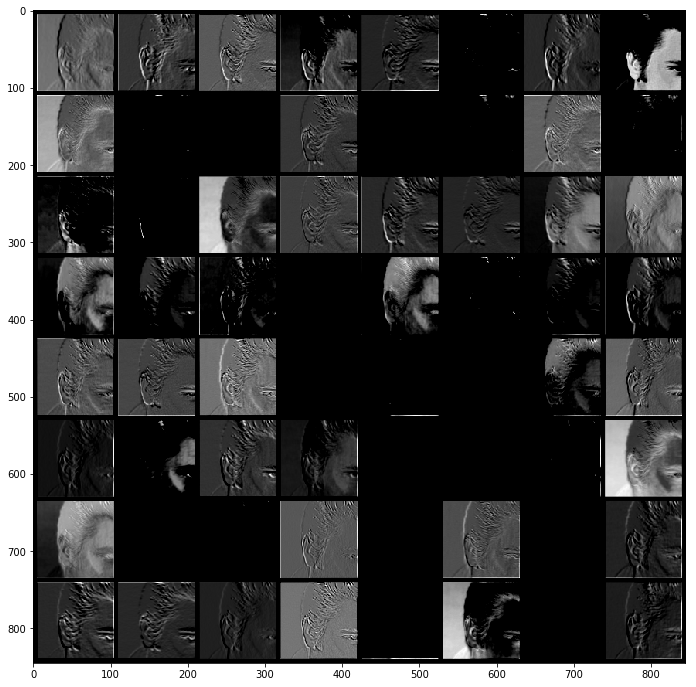

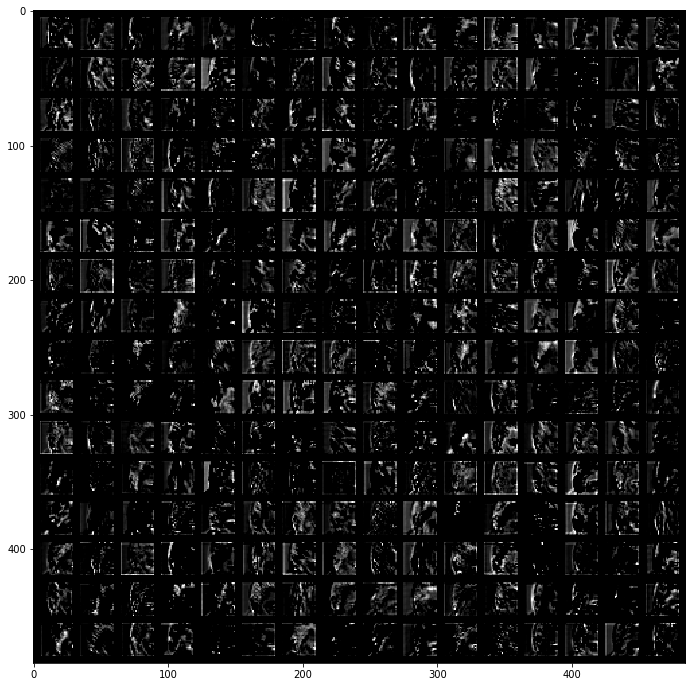

In [26]:
% matplotlib inline
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

conv1 = vgg16.features[:2] # first convolutional layer
print('conv1', conv1)

conv5 = vgg16.features[:12] # first convolutional layer
print('conv5', conv5)

for x,y in dataset_loader:
#     plt.figure()
#     plt.imshow(np.transpose(x[0].data.numpy(), (1,2,0)))
    out = conv1(x)
    out5 = conv5(x)
    print('input: ', x.shape, 'output: ', out.shape)
    show(make_grid(out[0].data.unsqueeze(1), nrow=8, scale_each=True, normalize=True, padding=5))
    show(make_grid(out5[0].data.unsqueeze(1), nrow=16, scale_each=True, normalize=True, padding=5))


